# Architecture Searching

This notebook aims to experiment with different model size to find a balance between accuracy and inference speed.
<br>Each model will be trained individually for a **fixed amount of epochs** with the **same seeding** for reproducability.

Different model sizes can is defined in `models/config/`
<br> **WARNING!! This process will take a significant amount of time!**

In [3]:
!nvidia-smi -L
device = 'cuda:0'

GPU 0: NVIDIA GeForce RTX 3080 (UUID: GPU-58d4b761-7fa1-8927-84ca-6f49200bea8f)


In [4]:
from utils.head import ensemble
from utils.dataset import load_compiled_data
from utils.training import train_aux, train_de
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torchinfo
import time
import os

device = torch.device(device)
offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]
divider = [[1895.24609375, 395.75, 175.25, 151.0],[1909.443359375, 396.5, 172.640625, 83.5]]

trajectory_threshold = [800, 700]

train_data = load_compiled_data(ts=[2,3,4], ws=[1], rs=[
                                1, 2], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, device=device, verbose=False)
test_data = load_compiled_data(ts=[2,3,4], ws=[1], rs=[
                               3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, device=device, verbose=False)

device = torch.device('cuda:0')
model_list = [['s_s', 's_m', 's_l'], ['m_s', 'm_m', 'm_l'], ['l_s', 'l_m', 'l_l']]
desc = 'big_dataset'
init_list = ['kaiming']

# Calibration Layer

Calibration layer (`input_reg`) will be trained for a total of **110k** training iterations with: 
- `1e-5` Learning rate for the first **10k** 
- `1e-6` for the rest.

Adam Optimizer is used throughout this training
<br> The obtained model will be saved in `models/head/{backup_directory}` folder for later use.

Note that each Calibration layer size will only be trained once.

In [5]:
backup_input_reg_directory = 'backup_input_reg'

In [ ]:
for init in init_list:
    try:
        os.mkdir(f'models/head/{backup_input_reg_directory}/{init}')
    except: 
        pass
    
    for ms in model_list:
        model_type = ms[0]
        model = ensemble(f'models/config/model_{model_type}.yaml', initializer=init, device=device)

        torch.manual_seed(0)
        random.seed(0)

        t0 = time.time()

        #aux
        optimizers = None
        input_reg_training_log = None
        model.input_regs, model.aux_head, epoch, optimizers, input_reg_training_log = train_aux(
            input_regs=model.input_regs,
            aux_head=model.aux_head,
            train_data=train_data,
            test_data=test_data,
            training_log=input_reg_training_log,
            optimizers_algortihm= 'Adam',
            total_epochs=10000,
            lr=1e-5,
            desc = f'{model_type}')
        model.epochs['aux'] += epoch
        model.input_regs, model.aux_head, epoch, optimizers, input_reg_training_log = train_aux(
            input_regs=model.input_regs,
            aux_head=model.aux_head,
            train_data=train_data,
            test_data=test_data,
            training_log=input_reg_training_log,
            optimizers_algortihm= 'Adam',
            total_epochs=100000,
            lr=1e-6,
            desc = f'{model_type}')
        model.epochs['aux'] += epoch
        model.training_log['aux'] = input_reg_training_log

        total_time = time.time() - t0

        for model_type in ms:

            training_dict = {'model_type': model_type,
                             'num_camera': 2,
                             'epochs': model.epochs,
                             'training_log': model.training_log,
                             'state_dict': {'input_reg': model.input_regs.state_dict(),
                                            'de': model.sequential_de.state_dict(),
                                            'aux': model.aux_head.state_dict()},
                              'training_time': total_time}
            torch.save(training_dict, f'models/head/{backup_input_reg_directory}/{init}/{model_type}.pt')

# Sequential DE

Sequential Layer (`sequential_de`) will be trained for a total of **2600** epochs with: 
- `1e-4` Learning rate for the first **100** Epochs
- `1e-5` Learning rate for the subsequent **1k** Epochs
- `1e-6` for the rest.

Adam Optimizer is used throughout this training
<br> Model with the **same calibration** layer size will used the **same trained weights** for the calibration layer

In [19]:
seed_list = [0,1,2,3,4]
init = 'kaiming'

In [34]:
reference_time = time.time()
for seed in seed_list:

    if not os.path.isdir(f'models/head/big_dataset/{init}_{seed}/'):
        os.mkdir(f'models/head/big_dataset/{init}_{seed}/')

    for ms in model_list:
        for i in range(0, 3):

            torch.manual_seed(seed)
            random.seed(seed)

            model_type = ms[i]

            model = ensemble(f'models/config/model_{model_type}.yaml',
                             model_state_dict=f'models/head/{backup_input_reg_directory}/{model_type}.pt', parts_to_load=['aux', 'input_reg'], device=device)

            t0 = time.time()

            # de
            optimizers = None
            de_training_log = None

            model.input_regs, model.sequential_de, epoch, optimizers, de_training_log = train_de(
                input_regs=model.input_regs,
                sequential_de=model.sequential_de,
                train_data=train_data,
                test_data=test_data,
                optimizers=optimizers,
                training_log=de_training_log,
                mode='random',
                optimizers_algortihm='Adam',
                total_epochs=100,
                lr=1e-4,
                desc=f'{seed} - {model_type}')
            model.epochs['de'] += epoch
            model.input_regs, model.sequential_de, epoch, optimizers, de_training_log = train_de(
                input_regs=model.input_regs,
                sequential_de=model.sequential_de,
                train_data=train_data,
                test_data=test_data,
                optimizers=optimizers,
                training_log=de_training_log,
                mode='random',
                optimizers_algortihm='Adam',
                total_epochs=1000,
                lr=1e-5,
                desc=f'{seed} - {model_type}')
            model.epochs['de'] += epoch
            model.input_regs, model.sequential_de, epoch, optimizers, de_training_log = train_de(
                input_regs=model.input_regs,
                sequential_de=model.sequential_de,
                train_data=train_data,
                test_data=test_data,
                optimizers=optimizers,
                training_log=de_training_log,
                mode='random',
                optimizers_algortihm='Adam',
                total_epochs=1500,
                lr=1e-6,
                desc=f'{seed} - {model_type}')
            model.epochs['de'] += epoch
            model.training_log['de'] = de_training_log

            total_time = time.time() - t0 + \
                torch.load(
                    f'models/head/{backup_input_reg_directory}/{model_type}.pt')['training_time']

            training_dict = {'model_type': model_type,
                             'num_camera': 2,
                             'epochs': model.epochs,
                             'training_log': model.training_log,
                             'state_dict': {'input_reg': model.input_regs.state_dict(),
                                            'de': model.sequential_de.state_dict(),
                                            'aux': model.aux_head.state_dict()},
                             'training_time': total_time}
            torch.save(
                training_dict, f'models/head/{desc}/{init}_{seed}/{model_type}.pt')

100%|#########9| 1495/1500 [1:08:38<00:13,  2.71s/it]

Epoch 1495
Training Mode: random
Desc: 4 - l_l

Loss:
    Train:
        Current : 1.5385680853796657e-06
        
    Test:
        Deep    : 2.1542648482864024e-06
        Shallow : 4.676069693232421e-06

MAPE 
    Train:
        Current : 0.15%
    Test:
        Deep    : 0.14%
        Shallow : 0.22%
    Test (Max):
        Deep    : 0.10 nm
        Shallow : 0.17 nm


In [35]:
# Total Training Time
print(time.time() - reference_time)

180290.9513938427


~ 50 hours run time ... 

# Result Analysis

Prediction will be made for every model with every intialization and seed. Inference time will also be saved.
<br>Final Prediction will be saved to `output/distance_estimator/{init}_{desc}_as.pkl`

In [3]:
from utils.head import ensemble
from utils.dataset import load_compiled_data
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchinfo
import pickle as pkl
import time
import os
import numpy as np

device = torch.device('cuda:0')

offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]
divider = [[1895.24609375, 395.75, 175.25, 151.0],
           [1909.443359375, 396.5, 172.640625, 83.5]]

torch.backends.cudnn.benchmark = True
trajectory_threshold = [800, 700]

test_data = load_compiled_data(ts=[2,3,4], ws=[1], rs=[
                               3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, inference_mode = True, device=device, verbose=False)
test_data['y'] = test_data['y']
ff = torch.any(torch.all(test_data['x'] != 0, dim = 2), dim = 0)

model_list = ['s_s', 's_m', 's_l', 'm_s', 'm_m', 'm_l', 'l_s', 'l_m', 'l_l']
seed_list = [0,1,2,3,4]
init_list = ['kaiming']
desc = 'big_dataset'

In [9]:
# Time dict Creation
for init in init_list:
    if os.path.exists(f'output/distance_estimator/{init}_{desc}_as.pkl'):
        with open(f'output/distance_estimator/{init}_{desc}_as.pkl', 'rb') as f:
            output_dict, time_dict = pkl.load(f)
    else:
        output_dict, time_dict = {}, {}
        
    time_dict = {i:torch.zeros(len(seed_list)) for i in model_list}
    output_dict = {i:torch.zeros(len(seed_list), test_data['x'][:, ff].shape[1]) for i in model_list}
    
    with open(f'output/distance_estimator/{init}_{desc}_as.pkl', 'wb') as f:
        pkl.dump([output_dict, time_dict], f)
        
    for model_type in model_list:
        for seed in seed_list:
            print(f"Inferencing Model {model_type}, Seed {seed}, {init} Initialization")
            model = ensemble(f'models/config/model_{model_type}.yaml', model_state_dict=f'models/head/{desc}/{init}_{seed}/{model_type}.pt', device=device, verbose=False)

            with open(f'output/distance_estimator/{init}_{desc}_as.pkl', 'rb') as f:
                output_dict, time_dict = pkl.load(f)
            if seed == seed[0]:
                x_test = torch.ones([2,1,4], device = device)

                #Warm-up
                for i in range(0, 100):
                    model(x_test, batch_mode = False)

                t0=time.time()
                for i in range(0, 100):
                    __ = model(x_test, batch_mode = False)
                time_dict[model_type] = (time.time() - t0) / 100

            output_dict[model_type][seed] = model(test_data['x'][:, ff]).cpu()

            with open(f'output/distance_estimator/{init}_{desc}_as.pkl', 'wb') as f:
                pkl.dump([output_dict, time_dict], f)

Inferencing Model s_s, Seed 0, kaiming Initialization
Inferencing Model s_s, Seed 1, kaiming Initialization
Inferencing Model s_s, Seed 2, kaiming Initialization
Inferencing Model s_s, Seed 3, kaiming Initialization
Inferencing Model s_s, Seed 4, kaiming Initialization
Inferencing Model s_m, Seed 0, kaiming Initialization
Inferencing Model s_m, Seed 1, kaiming Initialization
Inferencing Model s_m, Seed 2, kaiming Initialization
Inferencing Model s_m, Seed 3, kaiming Initialization
Inferencing Model s_m, Seed 4, kaiming Initialization
Inferencing Model s_l, Seed 0, kaiming Initialization
Inferencing Model s_l, Seed 1, kaiming Initialization
Inferencing Model s_l, Seed 2, kaiming Initialization
Inferencing Model s_l, Seed 3, kaiming Initialization
Inferencing Model s_l, Seed 4, kaiming Initialization
Inferencing Model m_s, Seed 0, kaiming Initialization
Inferencing Model m_s, Seed 1, kaiming Initialization
Inferencing Model m_s, Seed 2, kaiming Initialization
Inferencing Model m_s, Seed 

In [11]:
init = init_list[0]
with open(f'output/distance_estimator/{init}_{desc}_as.pkl', 'rb') as f:
    output_dict, time_dict = pkl.load(f)
best_mape = {}
for i in output_dict.keys():
    best_mape[i] = torch.mean(torch.mean(abs(output_dict[i].cuda() - test_data['y'][0, ff, 0]) * 100 / test_data['y'][0, ff, 0], axis = 1)).item()
output_s = [best_mape[i] for i in ['s_s', 's_m', 's_l']]
output_m = [best_mape[i] for i in ['m_s', 'm_m', 'm_l']]
output_l = [best_mape[i] for i in ['l_s', 'l_m', 'l_l']]
time_s = [time_dict[model_type] * 1000 for model_type in ['s_s', 's_m', 's_l']]
time_m = [time_dict[model_type] * 1000 for model_type in ['m_s', 'm_m', 'm_l']]
time_l = [time_dict[model_type] * 1000 for model_type in ['l_s', 'l_m', 'l_l']]

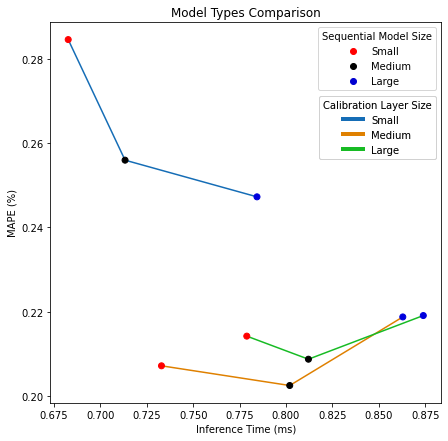

In [12]:
# Plotting Graph
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1,1, figsize = (7, 7))
cmap1 = plt.cm.flag
cmap2 = plt.cm.viridis
ax.scatter(time_s, output_s, c=[0,1,2], vmin=0, vmax=20, cmap = 'flag', zorder = 2)
ax.scatter(time_m, output_m, c=[0,1,2], vmin=0, vmax=20, cmap = 'flag', zorder = 2)
ax.scatter(time_l, output_l, c=[0,1,2], vmin=0, vmax=20, cmap = 'flag', zorder = 2)

ax.set_title("Model Types Comparison")
ax.set_ylabel('MAPE (%)')
ax.set_xlabel('Inference Time (ms)')

ax.plot(time_s, output_s, zorder = 1, c='#156DB6')
ax.plot(time_m, output_m, zorder = 1, c='#DF8000')
ax.plot(time_l, output_l, zorder = 1, c='#17BB24')


custom_lines_1 = [Line2D([0], [0], color=cmap1(0), lw=0, marker='o', markersize=6),
                Line2D([0], [0], color=cmap1(1000), lw=0, marker='o', markersize=6),
                Line2D([0], [0], color=cmap1(9), lw=0, marker='o', markersize=6)]

custom_lines_2 = [Line2D([0], [0], color='#156DB6', lw = 4),
                Line2D([0], [0], color='#DF8000', lw = 4),
                Line2D([0], [0], color='#17BB24', lw = 4)]


legend1 = ax.legend(custom_lines_1, ['Small', 'Medium', 'Large'], title= "Sequential Model Size", loc ='upper right')
ax.add_artist(legend1)
legend2 = ax.legend(custom_lines_2, ['Small', 'Medium', 'Large'], title="Calibration Layer Size", loc = 'upper center', bbox_to_anchor=[0.837, 0.82])
ax.add_artist(legend2)